# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="cifar10.jpg" style="width:80%">

# Import stuff

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.0.0
2.0.8


# Load dataset

In [2]:
from cifar import load_cifar10
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [3]:
#convert from [batch,3,H,W] to [batch,H,W,3]
#WARNING! Make this is only necessary for tensorflow-style dim order
#If you use theano-style dimensions in keras config, skip this cell
# x_train = x_train.transpose([0,2,3,1])
# x_val   = x_val.transpose([0,2,3,1])
# x_test  = x_test.transpose([0,2,3,1])
# print (x_train.shape,y_train.shape)

In [4]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)


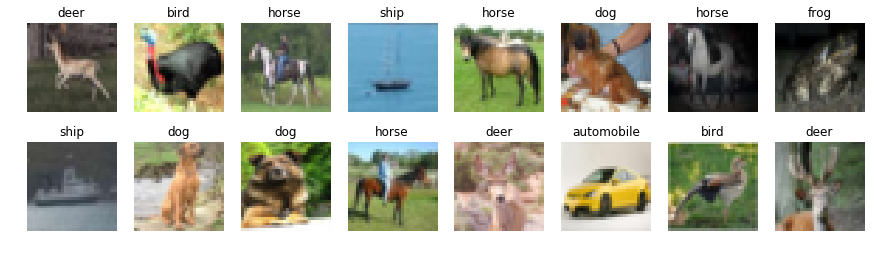

In [5]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

# Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [6]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train = x_train.astype('float32') - 0.5
x_val = x_test.astype('float32') - 0.5

# Define CNN architecture

In [7]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, AlphaDropout, Input, BatchNormalization, \
                         merge, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```


Train it with Adam optimizer with default params.


### Second step (after you've trained it)

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


In [8]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(Conv2D(48, (3, 3), padding='same', activation='selu', kernel_initializer='lecun_normal', 
                     input_shape=x_train.shape[1:]))
    model.add(Conv2D(48, (3, 3), activation='selu', kernel_initializer='lecun_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(96, (3, 3), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(Conv2D(96, (3, 3), activation='selu', kernel_initializer='lecun_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(192, (3, 3), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(Conv2D(192, (3, 3), activation='selu', kernel_initializer='lecun_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.5))
    model.add(Dense(256, activation='selu', kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [9]:
from keras.regularizers import l2
from keras.models import Model
from keras.layers.merge import concatenate

def conv_block(ip, nb_filter, dropout_rate=None, weight_decay=1E-4):
    x = Activation('relu')(ip)
    x = Conv2D(nb_filter, (3, 3), kernel_initializer="he_uniform", padding="same", use_bias=False,
                      kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(ip, nb_filter, dropout_rate=None, weight_decay=1E-4):
    concat_axis = 1 if K.image_dim_ordering() == "th" else -1

    x = Conv2D(nb_filter, (1, 1), kernel_initializer="he_uniform", padding="same", use_bias=False,
                      kernel_regularizer=l2(weight_decay))(ip)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    x = BatchNormalization(axis=concat_axis, gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    return x

def dense_block(x, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1E-4):
    concat_axis = 1 if K.image_dim_ordering() == "th" else -1

    feature_list = [x]

    for i in range(nb_layers):
        x = conv_block(x, growth_rate, dropout_rate, weight_decay)
        feature_list.append(x)
        x = concatenate(feature_list, axis=concat_axis)
        nb_filter += growth_rate

    return x, nb_filter

def make_densenet():
    depth=32
    nb_dense_block=3
    growth_rate=12
    nb_filter=16
    dropout_rate=None
    weight_decay=1E-4
    verbose=True
    
    model_input = Input(shape=x_train.shape[1:])

    concat_axis = -1

    # layers in each dense block
    nb_layers = int((depth - 4) / 3)

    # Initial convolution
    x = Conv2D(nb_filter, (3, 3), kernel_initializer="he_uniform", padding="same", name="initial_conv2D", \
               use_bias=False,
                      kernel_regularizer=l2(weight_decay))(model_input)

    x = BatchNormalization(axis=concat_axis, gamma_regularizer=l2(weight_decay),
                            beta_regularizer=l2(weight_decay))(x)

    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = dense_block(x, nb_layers, nb_filter, growth_rate, dropout_rate=dropout_rate,
                                   weight_decay=weight_decay)
        x = transition_block(x, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x, nb_filter = dense_block(x, nb_layers, nb_filter, growth_rate, dropout_rate=dropout_rate,
                               weight_decay=weight_decay)

    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(weight_decay),\
              bias_regularizer=l2(weight_decay))(x)

    densenet = Model(inputs=model_input, outputs=x, name="create_dense_net")
    
    return densenet

In [10]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 96)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 192)         166080    
__________

# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 128
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=Adam(lr=1e-3),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                        validation_data=(x_val, y_val),
                        epochs=EPOCHS, verbose=1, max_queue_size=100)

# fit model
#model.fit(
#    x_train, y_train,  # prepared data
#    batch_size=BATCH_SIZE,
#    epochs=EPOCHS,
#    validation_data=(x_test, y_test),
#    shuffle=True,
#)

Epoch 1/10
312/312 [==============================] - 615s - loss: 1.8071 - acc: 0.3392 - val_loss: 1.7222 - val_acc: 0.5043
Epoch 2/10
312/312 [==============================] - 698s - loss: 1.3577 - acc: 0.5130 - val_loss: 1.4148 - val_acc: 0.6069
Epoch 3/10
312/312 [==============================] - 709s - loss: 1.1382 - acc: 0.6010 - val_loss: 1.3916 - val_acc: 0.6793
Epoch 4/10
312/312 [==============================] - 666s - loss: 0.9937 - acc: 0.6592 - val_loss: 1.2978 - val_acc: 0.7173
Epoch 5/10
312/312 [==============================] - 721s - loss: 0.8930 - acc: 0.6955 - val_loss: 1.2504 - val_acc: 0.7402
Epoch 6/10
312/312 [==============================] - 600s - loss: 0.8212 - acc: 0.7225 - val_loss: 1.2078 - val_acc: 0.7655
Epoch 7/10
312/312 [==============================] - 625s - loss: 0.7680 - acc: 0.7406 - val_loss: 1.2259 - val_acc: 0.7707
Epoch 8/10
312/312 [==============================] - 622s - loss: 0.7177 - acc: 0.7609 - val_loss: 1.1099 - val_acc: 0.7943


In [11]:
# save weights to file
model.save_weights("weights.h5")

In [12]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [13]:
# make test predictions
y_pred_test = model.predict_proba(x_val)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

10000/10000 [==============================] - 46s    


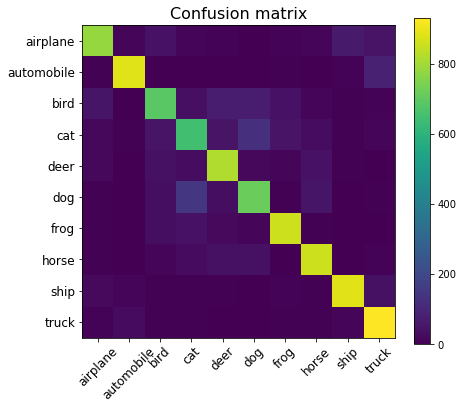

Test accuracy: 0.8072


In [14]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes), interpolation='none')
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

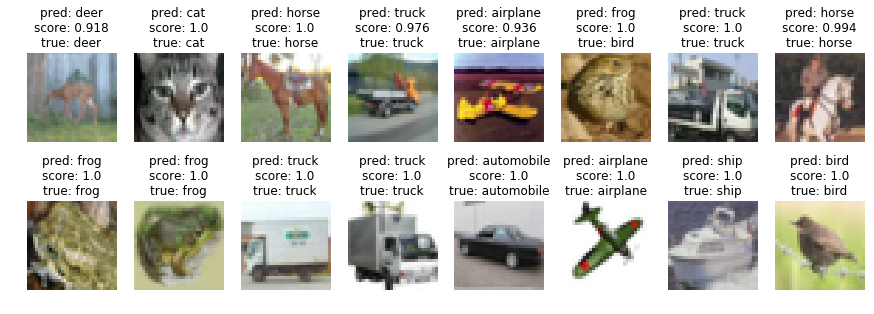

In [15]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Main: Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)
    
## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way